# 6. Predicting Personality Index

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On Static Gradients](#staticgrad)



In [3]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="staticgrad"></a>
## On Static Gradients

#### Visual difference

In [4]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad400.pkl')
subjects     = list(subject_grad.keys())
subjects     = list(subject_grad.keys())
regions      = list(index2region.keys())

L            = [subject_grad[s][:,:2] for s in subjects]
aligned, _ , score = procrustes_align(L)
subject_grad = {subjects[i]: aligned[i] for i in range(len(subjects))}

feat     = existing_psy[0]
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
order    = np.argsort(psyscore)

# for Display
G1,G2,coloring = [],[],[]
N, ncoloring   = [], []
gradients    = np.asarray([subject_grad[s] for s in subjects])
for i in order:
    G1       += list(gradients[i][:,0])
    G2       += list(gradients[i][:,1])
    N.append(np.linalg.norm(gradients[i][:,:2], axis=1))
    coloring += [psyscore[i]] * 400
    ncoloring.append([psyscore[i]] * 400)
N = np.asarray(N)
ncoloring = np.asarray(ncoloring)

Text(25.22222222222222, 0.5, 'G2')

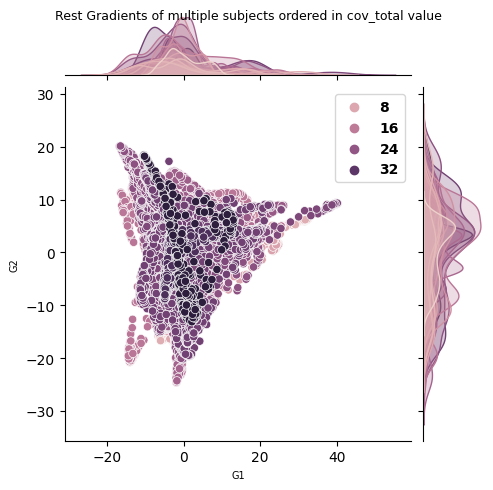

In [5]:
tmp_df = {"G1": G1 , "G2": G2, feat: coloring}

ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue=feat, height=5)
ax.fig.suptitle("Rest Gradients of multiple subjects ordered in {} value".format(feat), size=9)
legend_properties = {'weight':'bold','size':10}
ax.ax_joint.legend(prop=legend_properties,loc='upper right')
ax.ax_joint.set_xlabel('G1', size=7)
ax.ax_joint.set_ylabel('G2', size=7)

In [7]:
# correlation of first 5 gradients per parcel value with personality index
gradpsycorr = np.zeros((15,gradients.shape[1]))
for i in range(15):
    feat = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    
    for k in range(gradients.shape[1]):
        tmp1 = zscore(gradients[:,k,0])
        tmp2 = zscore(np.array(psyscore))
        corr = stats.pearsonr(tmp1, tmp2).statistic
        gradpsycorr[i][k] = corr

In [ ]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
grad = [None] * 15
for i in range(15):
    # map the gradient to the parcels
    grad[i] = map_to_labels(gradpsycorr[i], labeling, mask=mask, fill=np.nan)

print('First gradient')
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='bwr',
                 color_bar=True, label_text=existing_psy, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)

First gradient


### Regress / Predictive

#### Loadings

In [6]:
# Loading REST gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad400.pkl')
subjects     = list(subject_grad.keys())

subjects_order = list(subject_grad.keys())
regions        = list(index2region.keys())
print(subjects_order)

L            = [subject_grad[s] for s in subjects_order]
aligned, _ , score = procrustes_align(L, n_iter=10000, tol=1e-10)
gradients_rest     = np.asarray(deepcopy(aligned))

# Loading Supermovie gradients 
subject_grad = load('./resources/static_grad/individual_level/SUPERMOVIE_grad400.pkl')

L            = [subject_grad[s] for s in subjects_order]
aligned, _ , score = procrustes_align(L, n_iter=10000, tol=1e-10)
gradients_movie    = np.asarray(deepcopy(aligned))

['S17', 'S02', 'S05', 'S10', 'S11', 'S04', 'S19', 'S03', 'S16', 'S01', 'S14', 'S09', 'S13', 'S06', 'S07', 'S08', 'S15', 'S29', 'S21', 'S26', 'S27', 'S32', 'S20', 'S28', 'S22', 'S25', 'S30', 'S31', 'S24', 'S23']


#### Model Visualization

In [26]:
order_fixed = np.arange(30)
np.random.shuffle(order_fixed)

Movie based prediction

In [14]:
# initial statistic
np.random.seed(93)
kfold         = 3
lbd, rbd      = -5, 1
lambdas_lasso = np.logspace(lbd,rbd,50)
A             = gradients_movie.reshape(30,-1)

feat      = existing_psy[4]
psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
psyscore  = np.array(psyscore)

BP_movie = []
for i in tqdm(range(100)):
    results = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    BP_movie.append(results)
    
# null statistic    
null_BP_movie = []
for i in tqdm(range(100)):
    psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore  = np.array(psyscore)
    np.random.shuffle(psyscore)
    results   = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    null_BP_movie.append(results)    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(BP_movie)[:,:,0] > 0).sum(axis=1)==3)[0]))
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(null_BP_movie)[:,:,0] > 0).sum(axis=1)==3)[0]))

Good R^2 fit on all folds repeats [ 1  2  3  5  7  9 10 11 12 18 19 21 24 26 28 29 30 31 32 33 36 41 42 43
 44 45 46 48 49 50 52 54 57 61 64 67 68 70 73 74 77 79 80 81 82 83 84 86
 87 88 92 93 95 96]
Good R^2 fit on all folds repeats [ 2  6  8  9 14 20 42 44 62 76 88]


Text(0, 0.5, 'personality index value')

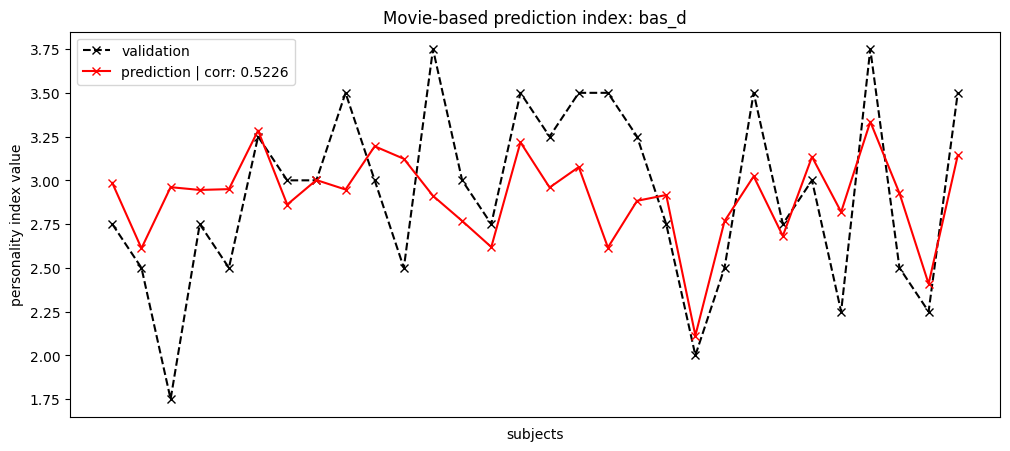

In [32]:
tmp1 = np.concatenate(np.asarray(BP_movie[5])[:,3])
tmp2 = np.concatenate(np.asarray(BP_movie[5])[:,2])
tmp3 = np.concatenate(np.asarray(null_BP_movie[11])[:,3])
tmp4 = np.concatenate(np.asarray(null_BP_movie[11])[:,2])

tmpcorr1 = pearson_correlation(tmp1,tmp2)
tmpcorr2 = pearson_correlation(tmp3,tmp4)

fig = plt.figure(figsize=(12,5))
ax  = fig.add_subplot(111)

plt.title('Movie-based prediction index: {}'.format(feat))

plt.plot(tmp1[np.argsort(tmp1)[order_fixed]], '--x', label='validation', c='k')
plt.plot(tmp2[np.argsort(tmp1)[order_fixed]], '-x', label='prediction | corr: {}'.format(round(tmpcorr1,4)), c='r')
# plt.plot(tmp3, '--x', label='validation 2', c='g')
# plt.plot(tmp4, '--x', label='prediction null | corr: {}'.format(round(tmpcorr2,4)))
plt.legend()

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_xlabel('subjects')
ax.set_ylabel('personality index value')

Rest based prediction

In [11]:
np.random.seed(93)
kfold         = 3
lbd, rbd      = -5, 1
lambdas_lasso = np.logspace(lbd,rbd,50)
A             = gradients_rest.reshape(30,-1)

feat      = existing_psy[4]
psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
psyscore  = np.array(psyscore)

# initial statistic
BP_rest = []
for i in tqdm(range(100)):
    results = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    BP_rest.append(results)
    
# null statistic    
null_BP_rest = []
for i in tqdm(range(100)):
    psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore  = np.array(psyscore)
    np.random.shuffle(psyscore)
    results   = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    null_BP_rest.append(results)    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(BP_rest)[:,:,0] > 0).sum(axis=1)==3)[0]))
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(null_BP_rest)[:,:,0] > 0).sum(axis=1)==3)[0]))

Good R^2 fit on all folds repeats [ 5  7 18 19 23 35 41 50 69 86 87]
Good R^2 fit on all folds repeats [ 5 31 56 61 62 65]


Text(0, 0.5, 'personality index value')

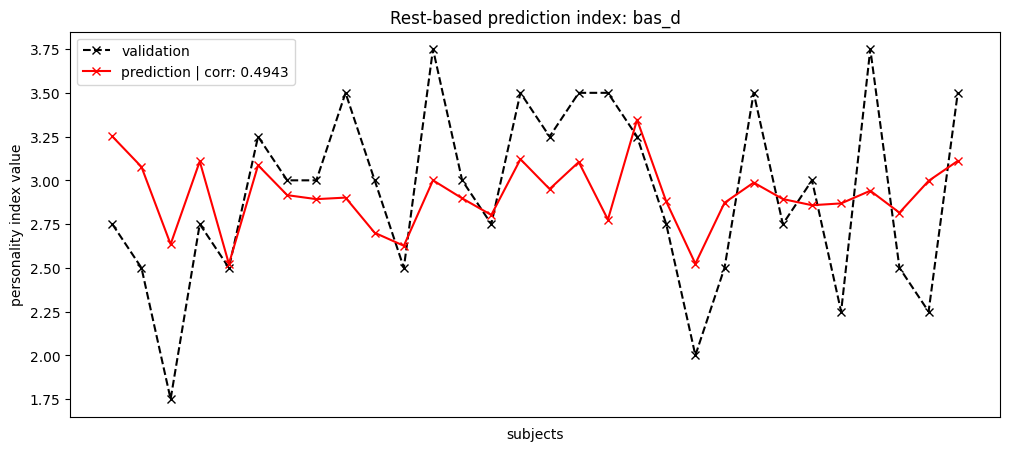

In [31]:
tmp1 = np.concatenate(np.asarray(BP_rest[87])[:,3])
tmp2 = np.concatenate(np.asarray(BP_rest[87])[:,2])
tmp3 = np.concatenate(np.asarray(null_BP_rest[78])[:,3])
tmp4 = np.concatenate(np.asarray(null_BP_rest[78])[:,2])


tmpcorr1 = pearson_correlation(tmp1,tmp2)
tmpcorr2 = pearson_correlation(tmp3,tmp4)

fig = plt.figure(figsize=(12,5))
ax  = fig.add_subplot(111)

plt.title('Rest-based prediction index: {}'.format(feat))

plt.plot(tmp1[np.argsort(tmp1)[order_fixed]], '--x', label='validation', c='k')
plt.plot(tmp2[np.argsort(tmp1)[order_fixed]], '-x', label='prediction | corr: {}'.format(round(tmpcorr1,4)), c='r')
# plt.plot(tmp3, '--x', label='prediction null | corr: {}'.format(round(tmpcorr2,4)))
plt.legend()

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_xlabel('subjects')
ax.set_ylabel('personality index value')

In [79]:
# save('./resources/tmp_ress/bp_movie.pkl', BP_movie)
# save('./resources/tmp_ress/bp_rest.pkl', BP_rest)

#### Lasso on Full gradients (3 gradients) with k-fold

##### With Movie

In [33]:
lbd,rbd = -5,1
lambdas_lasso = np.logspace(lbd,rbd,20)

In [34]:
# for k in logsnull.keys():
#     print(k)
#     print(round(np.nanmean(logsnull[k][0]),3), round(np.nanmean(logs[k][0]),3))
#     print(len(logsnull[k][0]), len(logs[k][0]))
#     print(round(np.nanmean(logsnull[k][2]),3), round(np.nanmean(logs[k][2]),3))
#     print()

In [36]:
np.random.seed(10)

logs_movie     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull_movie = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_movie.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, metric='R2', rd_state=i)
    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logs_movie[feat]  = best_res, best_coeffs, best_corrs

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, null=True, metric='R2', rd_state=i)

    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logsnull_movie[feat] = best_res, best_coeffs, best_corrs

  0%|          | 0/15 [00:00<?, ?it/s]

In [38]:
row = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 
        'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row:
    folds = logs_movie[r][2]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(folds)
    
    foldsN = logsnull_movie[r][2]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(foldsN)
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx']     += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx']     += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)

In [39]:
pred_distrib['null'] = 0
null_distrib['null'] = 1

  0%|          | 0/15 [00:00<?, ?it/s]

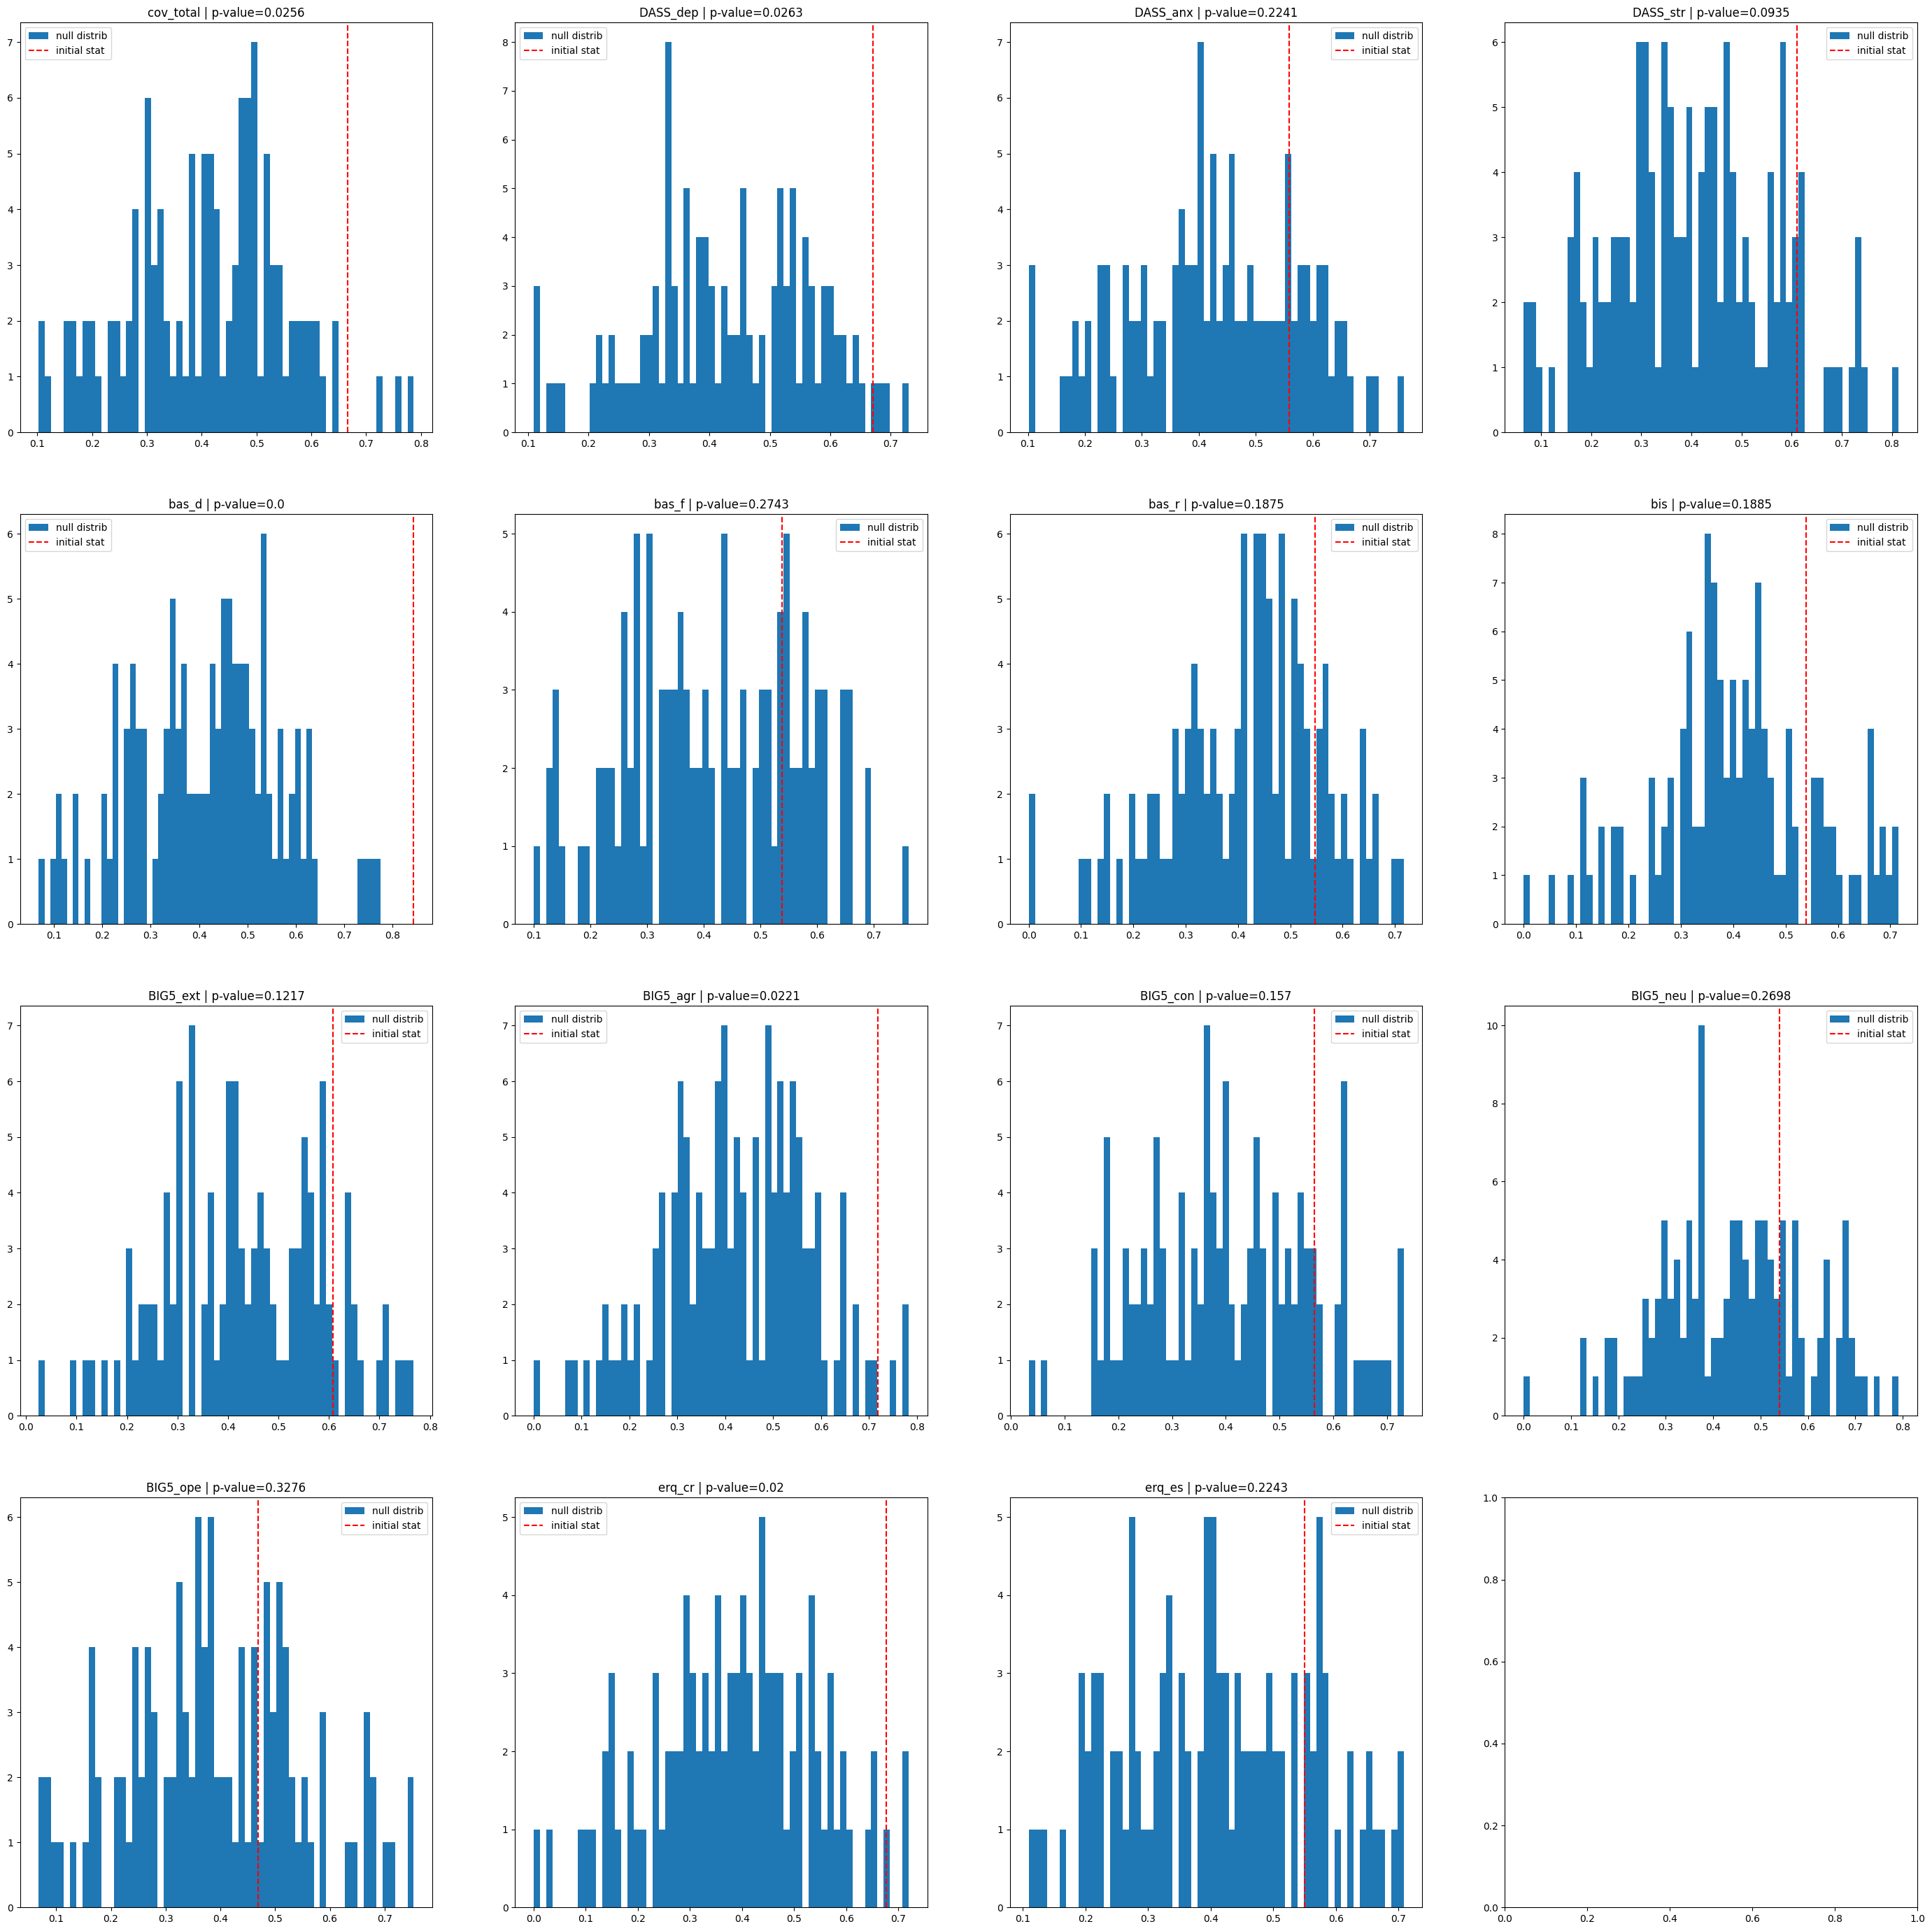

In [40]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

pvalues_movie = {}
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    initial_stat = pred_distrib[pred_distrib.pidx==feat].max()['foldcorr']
    ndistrib     = null_distrib[null_distrib.pidx==feat]['foldcorr']
    nscore       = null_score(ndistrib, initial_stat)
    pvalues_movie[feat]= round(nscore,4)
    
    ax[r,c].hist(ndistrib, 60, label='null distrib')
    ax[r,c].axvline(x = initial_stat, linestyle='--', 
                    color = 'r', label = 'initial stat')
    ax[r,c].legend()
    ax[r,c].set_title(feat + ' | p-value={}'.format(round(nscore,4)))

<AxesSubplot:xlabel='pidx', ylabel='foldcorr'>

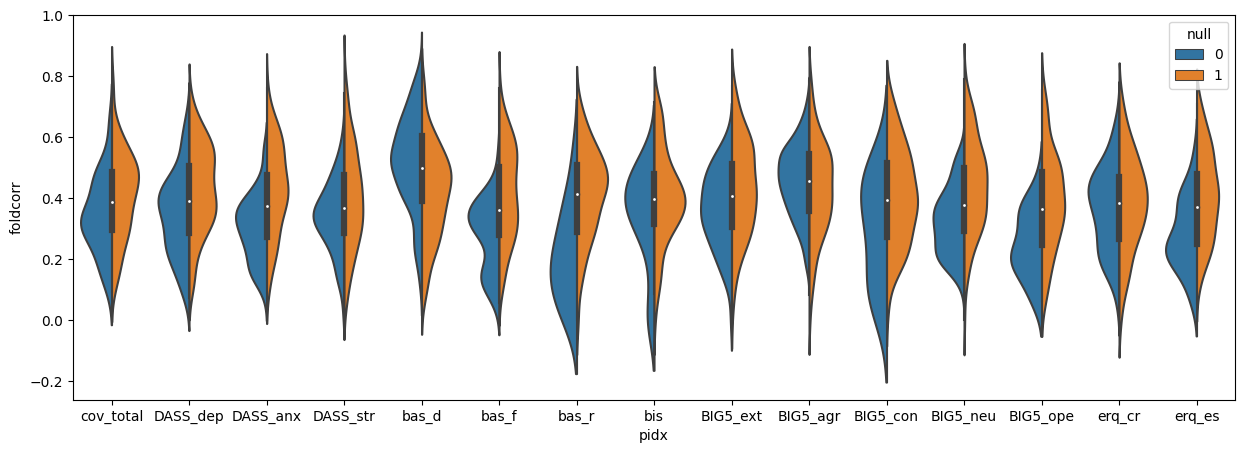

In [110]:
plt.figure(figsize=(15,5))
sns.violinplot(data=pd.concat([pred_distrib, null_distrib]).reset_index(drop=True), 
                x="pidx", y="foldcorr", hue="null", split=True)

##### With Rest

In [41]:
lbd,rbd = -5,1
lambdas_lasso = np.logspace(lbd,rbd,20)

In [42]:
np.random.seed(10)

logs_rest     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull_rest = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_rest.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, metric='R2', rd_state=i)
    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logs_rest[feat]  = best_res, best_coeffs, best_corrs

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, null=True, metric='R2', rd_state=i)

    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logsnull_rest[feat] = best_res, best_coeffs, best_corrs

  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
row = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 
        'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row:
    folds = logs_rest[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(folds)
    
    foldsN = logsnull_rest[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(foldsN)
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)

In [44]:
pred_distrib['null'] = 0
null_distrib['null'] = 1

Text(0.5, 1.0, 'Rest gradients personality prediction')

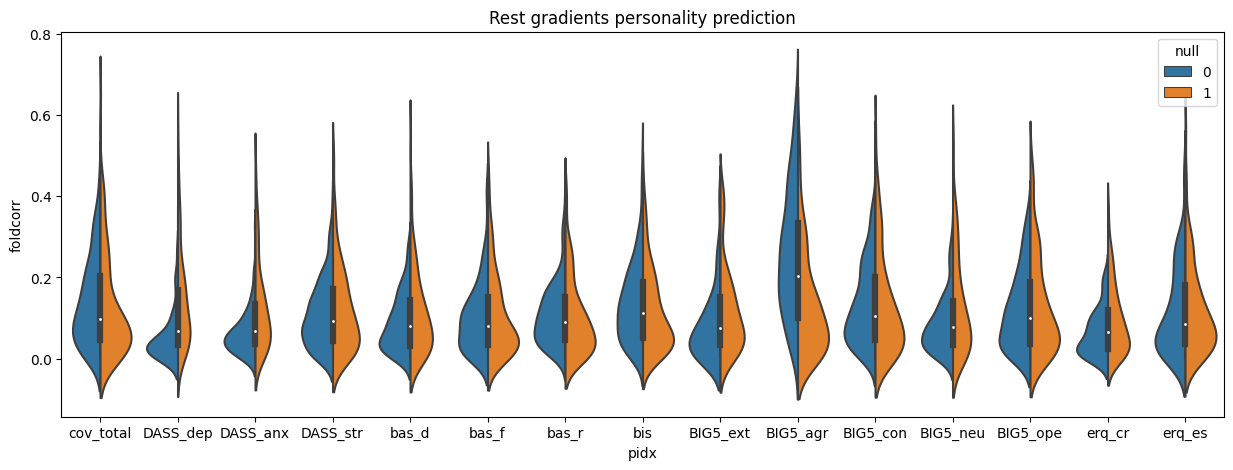

In [178]:
plt.figure(figsize=(15,5))
sns.violinplot(data=pd.concat([pred_distrib, null_distrib]).reset_index(drop=True), 
                x="pidx", y="foldcorr", hue="null", split=True)
plt.title('Rest gradients personality prediction')

  0%|          | 0/15 [00:00<?, ?it/s]

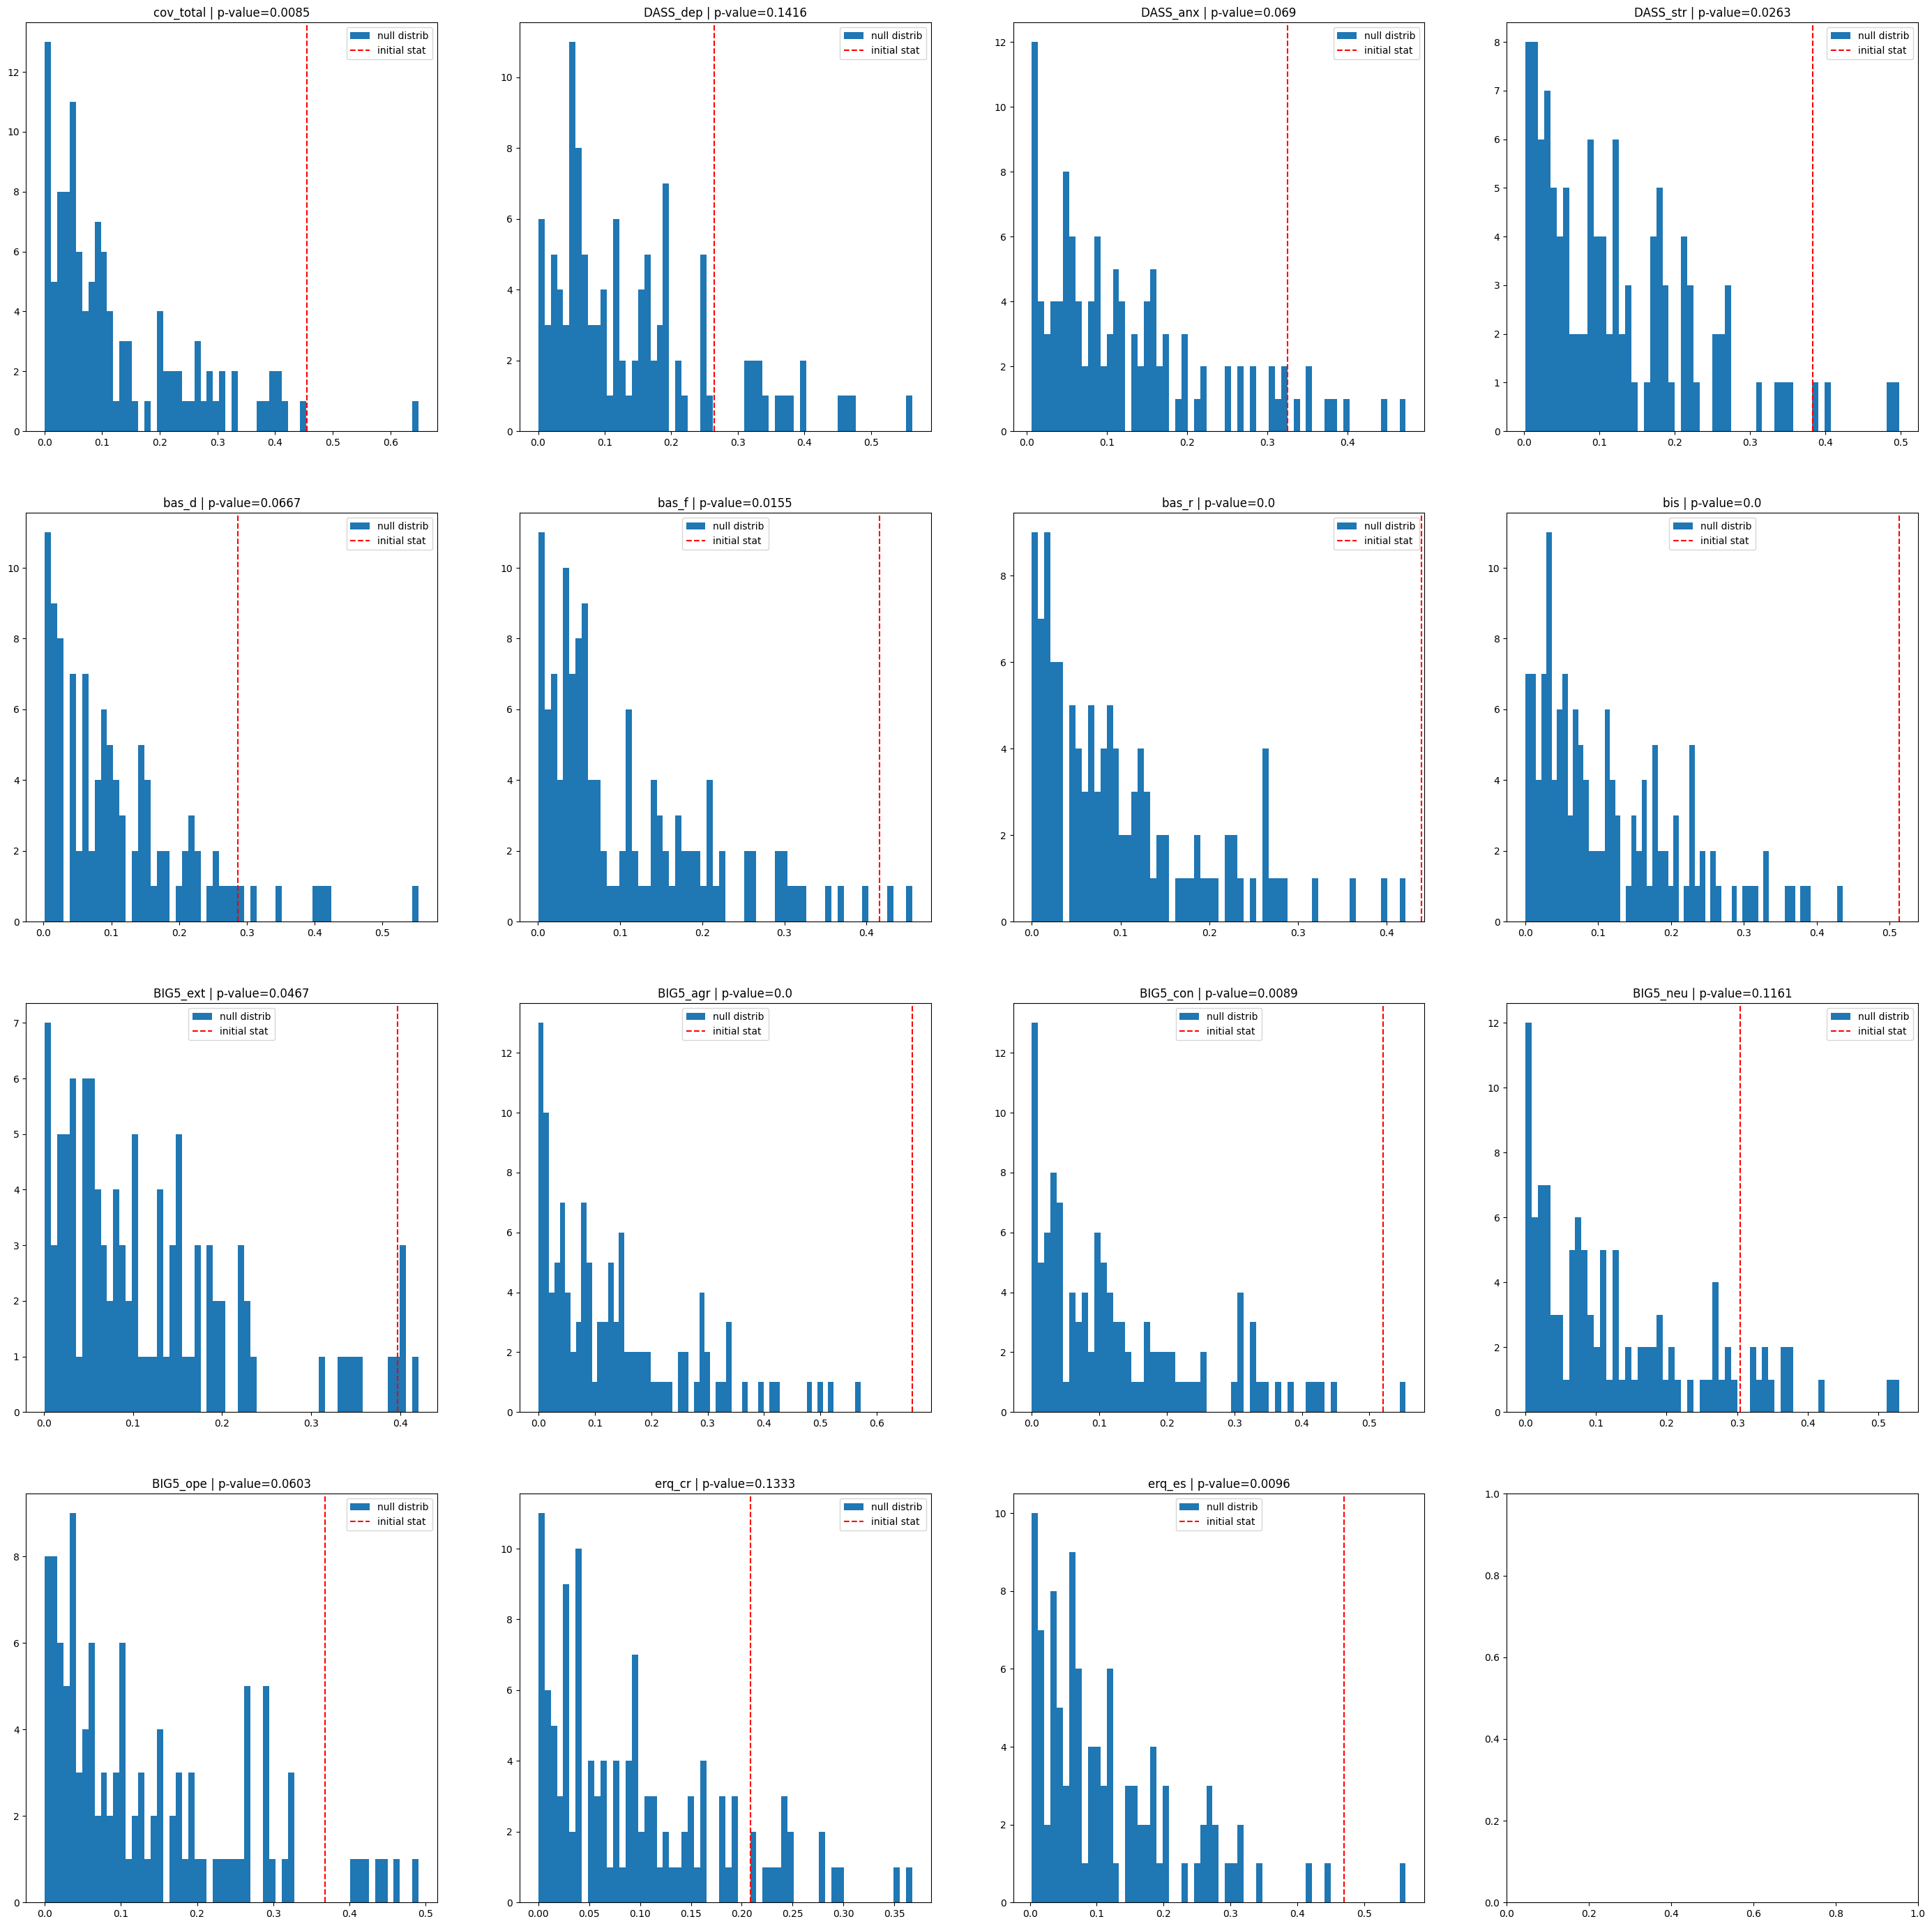

In [45]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

pvalues_rest = {}
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    initial_stat = pred_distrib[pred_distrib.pidx==feat].max()['foldcorr']
    ndistrib     = null_distrib[null_distrib.pidx==feat]['foldcorr']
    nscore       = null_score(ndistrib, initial_stat)
    pvalues_rest[feat]= round(nscore,4)
    
    ax[r,c].hist(ndistrib, 60, label='null distrib')
    ax[r,c].axvline(x = initial_stat, linestyle='--', 
                    color = 'r', label = 'initial stat')
    ax[r,c].legend()
    ax[r,c].set_title(feat + ' | p-value={}'.format(round(nscore,4)))

In [46]:
pvalues = {}
for k in pvalues_movie.keys():
    tmp1, tmp2 = pvalues_movie[k], pvalues_rest[k]
    pvalues[k] = [tmp1,tmp2]

tmp = pd.DataFrame.from_dict(pvalues)
tmp.index = ['film', 'rest']

In [61]:
print(tmp.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  cov\_total &  DASS\_dep &  DASS\_anx &  DASS\_str &   bas\_d &   bas\_f &   bas\_r &     bis &  BIG5\_ext &  BIG5\_agr &  BIG5\_con &  BIG5\_neu &  BIG5\_ope &  erq\_cr &  erq\_es \\
\midrule
film &     0.0256 &    0.0263 &    0.2241 &    0.0935 &  0.0000 &  0.2743 &  0.1875 &  0.1885 &    0.1217 &    0.0221 &    0.1570 &    0.2698 &    0.3276 &  0.0200 &  0.2243 \\
rest &     0.0085 &    0.1416 &    0.0690 &    0.0263 &  0.0667 &  0.0155 &  0.0000 &  0.0000 &    0.0467 &    0.0000 &    0.0089 &    0.1161 &    0.0603 &  0.1333 &  0.0096 \\
\bottomrule
\end{tabular}

